<a href="https://colab.research.google.com/github/lkrstic/stroke-image-registration/blob/main/stroke_image_registration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stroke Image Registration with MONAI
### Lana Krstic
### CAP 6683 - AI in Medicine and Healthcare

This demo will show how to perform image registration using the MONAI Core framework. We will load a set of MRI images showing ischemic stroke, then train a basic model. Each image will be paired with a copy which undergoes a series of transformations. The system should then predict which transformations took place between the paired images, and align them accordingly.

## Setup environment and imports

In [17]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [18]:
import os
import PIL
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.nn import MSELoss


from monai.utils import set_determinism, first
from monai.apps import download_url, download_and_extract
from monai.config import print_config, USE_COMPILED
from monai.data import DataLoader, Dataset, CacheDataset, pad_list_data_collate
from monai.networks.nets import DenseNet121, LocalNet, GlobalNet
from monai.networks.blocks import Warp
from monai.transforms import (
    Compose,
    Resized,
    EnsureChannelFirstD,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
)


print_config()

MONAI version: 1.1.dev2249
Numpy version: 1.21.6
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 6ac8fa0b0d0f475a8cceea86b12e448c19aeb050
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.13.1+cu113
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Prepare data directory

In [19]:
os.environ["MONAI_DATA_DIRECTORY"] = "data"

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

data


## Download and extract the dataset
Note: in order to run from colab, strokeMRI.zip must be placed **manually** into content/data. The code below only works to extract, it does not download correctly from the url.

The dataset used in this notebook is courtesy of the following paper:

B. Tasci, I. Tasci, Deep feature extraction based brain image classification model using preprocessed images: PDRNet, Biomedical Signal Processing and Control, 78 (2022) 103948. https://doi.org/10.1016/j.bspc.2022.103948

It can be downloaded at https://www.kaggle.com/datasets/buraktaci/mri-stroke

In [20]:
# resource = "https://github.com/lkrstic/stroke-image-registration/blob/e8a5b6e7abe003b99073d261e9da856f0718d00d/strokeMRI.zip"
resource = "https://www.dropbox.com/s/phymkgp6e8j1wt7/strokeMRI.zip"

compressed_file = os.path.join(root_dir, "strokeMRI.zip")
data_dir = os.path.join(root_dir, "strokeMRI")
if not os.path.exists(data_dir):
  # this will extract successfully from an existing zip file, but downloading does not work.
  download_and_extract(resource, compressed_file, root_dir)

## Analyze the data

Read the images into a list and print out some basic stats. Then select some random samples to visualize before processing.

In [21]:
image_files = [
    os.path.join(data_dir, x) for x in os.listdir(data_dir)
]

count = len(image_files)
image_width, image_height = PIL.Image.open(image_files[0]).size

print(f"Total image count: {count}")
print(f"Image dimensions: {image_width} x {image_height}")

Total image count: 199
Image dimensions: 610 x 488


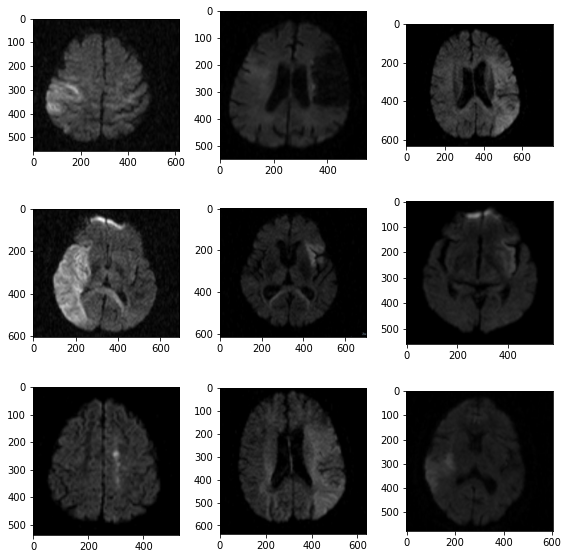

In [22]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(count, size=9)):
    im = PIL.Image.open(image_files[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Preprocess the data

Each image is saved twice in order to create training pairs. The "fixed" image will remain as the default, while the "moving" image will be subject to transforms before training can begin.

In [23]:
datadict = [
    {
        "fixed": img,
        "moving": img,
    }
    for img in image_files
]

## Transforms

The compose() functions allows us to outline how the transforms will be applied ot the image. e.g. both fixed and moving samples will be resized to uniform dimensions, while only the moving samples will be zoomed and rotated.

In [24]:
train_transforms = Compose(
    [
        LoadImageD(keys=["fixed", "moving"]),
        EnsureChannelFirstD(keys=["fixed", "moving"]),
        ScaleIntensityRanged(keys=["fixed", "moving"],
                             a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
        RandRotateD(keys=["moving"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
        RandZoomD(keys=["moving"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
        Resized(
            keys=["fixed", "moving"],
            mode=('bicubic', 'bicubic'),
            align_corners=(True, True),
            spatial_size=(128, 128)
        ),
    ]
)

## Check transforms

We can visualize a single training pair to confirm that the transforms are correctly defined before applying them to the entire training set.

moving_image shape: torch.Size([128, 128])
fixed_image shape: torch.Size([128, 128])


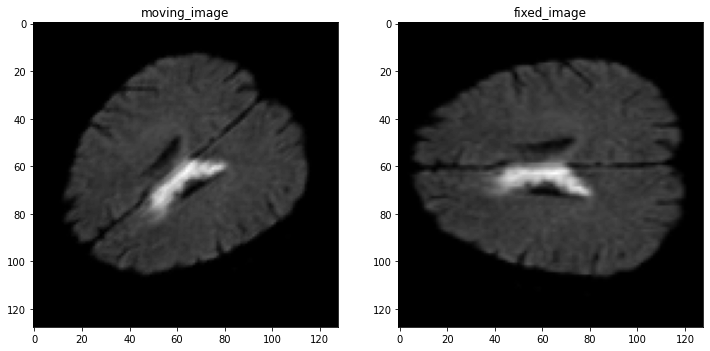

In [25]:
check_ds = Dataset(data=datadict, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)
check_data = first(check_loader)
fixed_image = check_data["fixed"][0][0]
moving_image = check_data["moving"][0][0]

print(f"moving_image shape: {moving_image.shape}")
print(f"fixed_image shape: {fixed_image.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("moving_image")
plt.imshow(moving_image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("fixed_image")
plt.imshow(fixed_image, cmap="gray")

plt.show()

## Training

- Next, we split the data into training and validation sets. CacheDataset() allows the training to run faster when done locally. Alternatively, Dataset() can be used when memory is limited.
- Then, define the model and system parameters
- Begin training

In [26]:
train_files, val_files = datadict[:99], datadict[99:]

In [27]:
train_ds = CacheDataset(data=train_files, transform=train_transforms,
                        cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2, collate_fn=pad_list_data_collate)

Loading dataset: 100%|██████████| 99/99 [00:04<00:00, 21.76it/s]


In [28]:
device = torch.device("cpu")
model = GlobalNet(
    image_size=(128, 128),
    spatial_dims=2,
    in_channels=6,
    num_channel_initial=16,
    depth=3).to(device)
image_loss = MSELoss()
warp_layer = Warp().to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

In [29]:
max_epochs = 200
epoch_loss_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss, step = 0, 0
    for batch_data in train_loader:
        step += 1
        optimizer.zero_grad()

        moving = batch_data["moving"].to(device)
        fixed = batch_data["fixed"].to(device)
        ddf = model(torch.cat((moving, fixed), dim=1))
        pred_image = warp_layer(moving, ddf)

        loss = image_loss(pred_image, fixed)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
        #       f"train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")


----------
epoch 1/200
epoch 1 average loss: 0.0120
----------
epoch 2/200
epoch 2 average loss: 0.0081
----------
epoch 3/200
epoch 3 average loss: 0.0087
----------
epoch 4/200
epoch 4 average loss: 0.0068
----------
epoch 5/200
epoch 5 average loss: 0.0054
----------
epoch 6/200
epoch 6 average loss: 0.0055
----------
epoch 7/200
epoch 7 average loss: 0.0056
----------
epoch 8/200
epoch 8 average loss: 0.0050
----------
epoch 9/200
epoch 9 average loss: 0.0045
----------
epoch 10/200
epoch 10 average loss: 0.0042
----------
epoch 11/200
epoch 11 average loss: 0.0042
----------
epoch 12/200
epoch 12 average loss: 0.0048
----------
epoch 13/200
epoch 13 average loss: 0.0056
----------
epoch 14/200
epoch 14 average loss: 0.0053
----------
epoch 15/200
epoch 15 average loss: 0.0045
----------
epoch 16/200
epoch 16 average loss: 0.0045
----------
epoch 17/200
epoch 17 average loss: 0.0048
----------
epoch 18/200
epoch 18 average loss: 0.0047
----------
epoch 19/200
epoch 19 average loss:

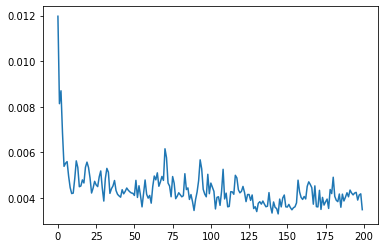

In [30]:
%matplotlib inline
plt.plot(epoch_loss_values)

## Validation example

Now the model can be tested on the validation images that were set aside earlier.

In [31]:
val_ds = CacheDataset(data=val_files, transform=train_transforms,
                      cache_rate=1.0, num_workers=0)
# val_ds = Dataset(data=val_files, transform=val_transforms)

val_loader = DataLoader(val_ds, batch_size=16, num_workers=2)

for batch_data in val_loader:
    moving = batch_data["moving"].to(device)
    fixed = batch_data["fixed"].to(device)
    ddf = model(torch.cat((moving, fixed), dim=1))
    pred_image = warp_layer(moving, ddf)
    break

fixed_image = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]

Loading dataset: 100%|██████████| 100/100 [00:05<00:00, 18.66it/s]


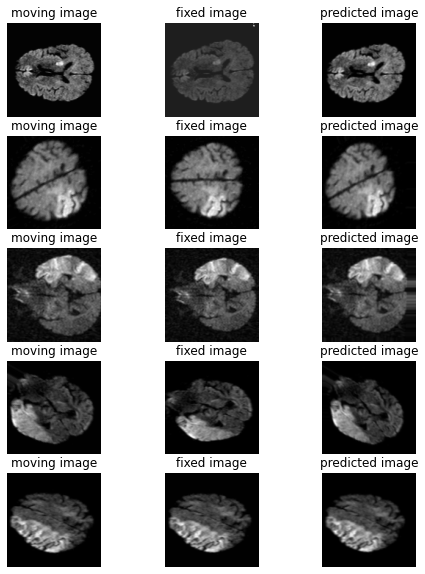

In [32]:
%matplotlib inline
batch_size = 5
plt.subplots(batch_size, 3, figsize=(8, 10))
for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 3, b * 3 + 1)
    plt.axis('off')
    plt.title("moving image")
    plt.imshow(moving_image[b], cmap="gray")
    # fixed image
    plt.subplot(batch_size, 3, b * 3 + 2)
    plt.axis('off')
    plt.title("fixed image")
    plt.imshow(fixed_image[b], cmap="gray")
    # warped moving
    plt.subplot(batch_size, 3, b * 3 + 3)
    plt.axis('off')
    plt.title("predicted image")
    plt.imshow(pred_image[b], cmap="gray")
plt.axis('off')
plt.show()